# Sequence to Sequence + Attention Model



## Table of Contents
---

* [Problem](#Problem)
* [Solution](#Solution)
    * [Logistics](#1.-Logistics)
    * [Data preprocessing](#2.-Data-Preprocessing)  
        * [Training & Validate Data Preperation](#Training-&-Validate-Data-Preparation)
        * [Test Data Exploration](#Test-Data-Exploration)
    * [Model](#3.-Model)  
        * [Architecture of Encoder](#Architecture-of-Encoder)  
        * [Architecture of Decoder: Vanilla LSTM](#Architecture-of-Decoder:-Vanilla-LSTM)  
        * [Architecture of Decoder: LSTM with Attention](#Architecture-of-Decoder:-LSTM-+-Attention)    
    * [Training](#4.-Training)
        * [Encoder + Vanilla LSTM Decoder](#Train-the-Model:-Vanilla-Seq2Seq)
        * [Encoder + LSTM with Attention Decoder](#Train-the-Model:-Seq2Seq-+-Attention)
    * [Evaluation](#5.-Evaluation)
        * [With validation data](#With-validation-data)
        * [With test data](#With-test-data)
    * [Analysis & Discussion](#6.-Analysis-&-Discussion)

**Note**: *Some of code snippets are inherited and extended from Gustavo's sample-by-sample Seq2Seq model. I really appreciate his sharing about Attention model. It is very informative and explained in a very easy-to-understand way.*  


## Problem

Build a Seq2Seq + Attention model and compare with vanilla Seq2Seq LSTM model.

## Solution

### 1. Logistics

In [0]:
# !pip install torchviz

In [0]:
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score
from datetime import datetime
from matplotlib import pyplot as plt
from google.colab import drive
from torchviz import make_dot

torch.manual_seed(1)
random.seed(1)

%matplotlib inline

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
# Normally, the model won't be retrained as model.pt file existed
# This constant forces to retrain the model
FORCE_RETRAIN = False

MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/data/NLP/HW3/output'
MODEL_PATH_SEQ2SEQ = '%s/seq2seq.pt' % MODEL_PATH
MODEL_PATH_SEQ2SEQ_ATTENTION = '%s/seq2seq+attn.pt' % MODEL_PATH
MODEL_PATH_SEQ2SEQ_LOSS = '%s/seq2seq.loss.pt' % MODEL_PATH

MODEL_EXISTED_SEQ2SEQ = os.path.isfile(MODEL_PATH_SEQ2SEQ)
MODEL_EXISTED_SEQ2SEQ_ATTENTION = os.path.isfile(MODEL_PATH_SEQ2SEQ_ATTENTION)

TEST_DATA_PATH = '/content/drive/My Drive/Colab Notebooks/data/NLP/HW3/data/test.txt'

if MODEL_EXISTED_SEQ2SEQ:
    print('Note: Model Seq2Seq existed')

if MODEL_EXISTED_SEQ2SEQ_ATTENTION:
    print('Note: Model Seq2Seq+Attention existed')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook is using: %s' % DEVICE)

Note: Model Seq2Seq existed
Note: Model Seq2Seq+Attention existed
This notebook is using: cuda


### 2. Data Preprocessing

#### Training & Validate Data Preparation
Our automatically-generated data will contain sequences with repeated and unordered letters. Such sequences must be mapped to alphabetically-sorted sequences of unique letters. Here are a few examples:
```
ccccaaabb        ->   abc
vvvrxduuu        ->   druvx
sddvvvzzuuuxxx   ->   dsuvxz
```


In [0]:
def sorting_letters_dataset(size):
    dataset = []
    for _ in range(size):
        x = []
        for _ in range(random.randint(3, 10)):
            letter = chr(random.randint(97, 122))
            repeat = [letter] * random.randint(1, 3)
            x.extend(repeat)
        y = sorted(set(x))
        dataset.append((x, y))
    return zip(*dataset)

We will have two splits in our data, one for **training**, and another for validation. The training set will be **20,000** samples and we will use this set to update the parameters of the model. The **validation** set will be **5,000** samples, which we use to select the best model.


In [0]:
class Vocab:
    def __init__(self, vocab):
        self.itos = vocab
        self.stoi = {d:i for i, d in enumerate(self.itos)}
        
    def __len__(self):
        return len(self.itos) 
    
src_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)])
tgt_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)] + ['<start>', '<stop>'] )

train_inp, train_out = sorting_letters_dataset(20_000)
valid_inp, valid_out = sorting_letters_dataset(5_000)

Now, we need to map the text data into numeric values. These numeric values are indexes that correspond to the entries in the embedding lookup table.
    
**Batch Processing**  
As we need to implement batch processing to our model. 
We need to make sure every input and output has the same length. Therefore, we add padding token, annotated as `<pad>`, and ending token, annotated as `<stop>` by the end of each sequence. A token `<start>` is also used in the vocabulary set of output to annotate the starting point of a sequence.   

As output is a ordered character-deduplicated version of input, output is much shorter than input. So that, we use different length of sequence to adapt the nature of data. This variance of length helps to reduce the redundant computation if using the same length for input and output. In this case, we have the max length of input is **28** and max length of output is **10**.  

In addition, this process also allows to extend the maximum length of the sequence as the test data might have different length.

In [90]:
START_IX = tgt_vocab.stoi['<start>']
STOP_IX  = tgt_vocab.stoi['<stop>']

def max_len(elems):
  return max([len(i) for i in elems])

# SEQ_LENGTH = max(max_len(train_inp), max_len(valid_inp))
SEQ_INPUT_LENGTH = max_len(train_inp)
SEQ_OUTPUT_LENGTH = max_len(train_out)

print('Max Input Length:', SEQ_INPUT_LENGTH)
print('Max Output Length:', SEQ_OUTPUT_LENGTH)

def map_elems(elems, mapper, seq_type='input', seq_length=None):
    if seq_type == 'input':
        pad_index = mapper['<pad>']
        max_length = seq_length or SEQ_INPUT_LENGTH
        assert len(elems) <= max_length, ("Invalid string: %s" % str(elems))
        return [mapper[elem] for elem in elems] + ([pad_index] * (max_length - len(elems)))
    elif seq_type == 'output':
        pad_index = STOP_IX
        max_length = seq_length or SEQ_OUTPUT_LENGTH
        assert len(elems) <= max_length, ("Invalid string: %s" % str(elems))
        return [mapper[elem] for elem in elems] + ([pad_index] * (max_length - len(elems)))

def map_many_elems(many_elems, mapper, seq_type='input', seq_length=None):
    return [map_elems(elems, mapper, seq_type=seq_type, seq_length=seq_length) for elems in many_elems]

train_x = map_many_elems(train_inp, src_vocab.stoi, seq_type='input')
train_y = map_many_elems(train_out, tgt_vocab.stoi, seq_type='output')

valid_x = map_many_elems(valid_inp, src_vocab.stoi, seq_type='input')
valid_y = map_many_elems(valid_out, tgt_vocab.stoi, seq_type='output')

Max Input Length: 28
Max Output Length: 10


In [91]:
# Validate the data
print(train_inp[0])
print(train_x[0])
assert len(train_x[0]) == SEQ_INPUT_LENGTH, "Invalid length"

print(train_out[0])
print(train_y[0])
assert len(train_y[0]) == SEQ_OUTPUT_LENGTH, "Invalid length"

['s', 'i', 'p', 'p', 'p', 'p', 'p', 'm']
[19, 9, 16, 16, 16, 16, 16, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['i', 'm', 'p', 's']
[9, 13, 16, 19, 28, 28, 28, 28, 28, 28]


#### Test Data Exploration

As we see here the length of Test data (**58**) is much higher than what we have in training and validating data.

In [92]:
import pandas as pd

test_data = pd.read_csv(TEST_DATA_PATH, delimiter='\t', header=None, usecols=[0,1])
test_inp, test_out = test_data[0], test_data[1]

print('Total test cases: %s' % len(test_inp))
print('Max length of input: %s' % max([len(i) for i in test_inp]))
print('Min length of input: %s' % min([len(i) for i in test_inp]))
print('Max length of output: %s' % max([len(o) for o in test_out]))
print('Min length of output: %s' % min([len(o) for o in test_out]))
print('Max repeated length: %s (In=%s, Out=%s)' % (max([len(w)/len(test_out[idx]) for idx, w in enumerate(test_inp)]), 
                                              test_inp[[len(w)/len(test_out[idx]) for idx, w in enumerate(test_inp)].index(8)],
                                              test_out[[len(w)/len(test_out[idx]) for idx, w in enumerate(test_inp)].index(8)]))

Total test cases: 5000
Max length of input: 58
Min length of input: 3
Max length of output: 13
Min length of output: 2
Max repeated length: 8.0 (In=lllllllfffflllll, Out=fl)


### 3. Model

#### Architecture of Encoder
Our encoder will be a simple LSTM model with one layer and one direction. For batch processing, a batch of same-size sequences are fed in the encoder to generate the encoder states.


<img src='https://github.com/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/images/encoder.png?raw=1' width='50%'/>

<small>Photo Credit: Gustavo's slide</small>

**Explanation**
- $h_i$ is the short-term state.
- $c_i$ is the long-term state.

**Two types of outputs**
- Last state: $z$ = $h_n$ and $c_n$. This is used in Vanilla Seq2Seq model.
- All states: $(h_1, h_2, ..., h_n)$ and $(c_1, c_2, ..., c_n)$. This is used in Seq2Seq + Attention model.

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, z_type, dropout=0.5):
        super(Encoder, self).__init__()
        self.z_index = z_type
        
        self.hidden_dim = hidden_dim

        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, inputs):
        device = next(self.parameters()).device
        seq = torch.tensor(inputs).to(device) # (1, seqlen)
        emb = self.emb(seq) # (1, seqlen, emb_dim)
        batch_size = seq.size(0)
        emb = self.drop(emb) 
        
        outs, (h_n, c_n) = self.lstm(emb)

        assert outs.size(0) == batch_size
        # assert outs.size(1) == SEQ_INPUT_LENGTH
        assert outs.size(2) == self.hidden_dim

        if self.z_index == 1:
            return h_n[0], c_n[0] # (seqlen, lstm_dim)
        else:
            return outs # (1, seqlen, lstm_dim)


**Structure of the Encoder**
- *Embedding Module*: A batch of sequences is embedded after being fed in the encoder. This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.
- *Dropout Module*: Embedded batch is dropped out. This helps for regularization and preventing the co-adaptation of neurons as described in the paper [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/abs/1207.0580). During training, randomly zeroes some of the elements of the input tensor with probability $p$ using samples from a $Bernoulli$ distribution.
- *Unidirectional LSTM*: LSTM is applied to learn the pattern of the sequence.

Encoder(
  (emb): Embedding(27, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
)


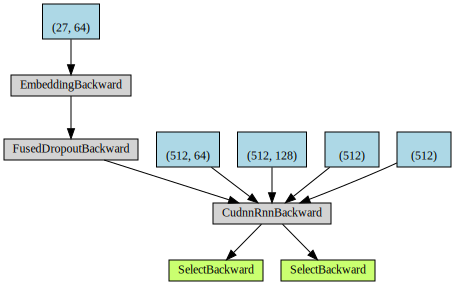

In [100]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=1)
encoder.to(DEVICE)
test_state = encoder(train_x[0:5])

print(encoder)
make_dot(test_state)

#### Architecture of Decoder: Vanilla LSTM

Similar to the encoder, the decoder will be a LSTM cell with one layer and one direction. 

<img src='https://github.com/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/images/decoder.png?raw=1' width='50%'/>

<small>Photo Credit: Gustavo's slide</small>

**Explanation**
- $y_i$ is the actual token in the output sequence.
- $q_i$ is the query vector or short-term state at step $i$.
- $\hat y_i$ is the predicted token at step $i$.
- $z$ is the state generated from encoder.

In [0]:
from torch.nn import functional as F

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, dropout=0.5):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTMCell(emb_dim, hidden_dim)
        self.drop = nn.Dropout(dropout)
        self.clf = nn.Linear(hidden_dim, vocab_size)
        self.objective = nn.CrossEntropyLoss(reduction="sum")
        
    def forward(self, state, targets, curr_token, last_token):
        device = next(self.parameters()).device
        
        loss = 0
        shifted = [t + [last_token] for t in targets]
        batch_size = state[0].shape[0]
        seq_len = len(targets[0]) + 1

        curr_tokens = [curr_token] * batch_size
        for i in range(seq_len):
            inp = torch.tensor(curr_tokens).to(device)
            
            emb = self.emb(inp)
            emb = self.drop(emb)
            
            state = self.lstm(emb, state)
            q_i, _ = state 
            q_i = self.drop(q_i)

            scores = self.clf(q_i)

            outs = [t[i] for t in shifted]
            target = torch.tensor(outs).to(device)
            loss += self.objective(scores, target)   
            curr_tokens = outs

        return loss / seq_len

    def predict(self, state, curr_token, last_token, maxlen=15):
        device = next(self.parameters()).device
        batch_size = state[0].shape[0]
        preds = []
        
        for i in range(maxlen):
            inp = torch.tensor([curr_token]).to(device)
            emb = self.emb(inp)
            
            state = self.lstm(emb, state)
            h_i, _ = state
            
            scores = self.clf(h_i)
            pred = torch.argmax(torch.softmax(scores, dim=1))
            curr_token = pred
            
            if last_token == pred:
                break
            preds.append(pred)
        return preds


**Structure of the Vanilla LSTM Decoder**
- *Embedding Module*: Similar to what we have in the encoder though the input to this module is $z$ state which is generated from encoder.
- *LSTM Cell*: LSTM is applied to learn the pattern of the sequence. We use a LSTM cell here and implement since it only return only the last state. So that we can implement a loop of learning with the number of interation is equal to the length of the output sequence.
- *Dropout Module*: Similar to what we have in the encoder.
- *Linear Module*: To transform the $q_i$ query vector to a vector in vocabulary space.
- *Cross Entropy Loss*: To compute the different between prediction and actual token. This module is a combination of both *Log Softmax Loss* and *Negative Log Likelihood Loss*. It is useful when training a classification problem with C classes. In our case, we try to predict a character in a set of vocabulary. Because we are processing batch-by-batch, we enable the reduction step to summarize all the losses of each sequence.


In [103]:
decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128)
print(decoder)

Decoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (drop): Dropout(p=0.5, inplace=False)
  (clf): Linear(in_features=128, out_features=29, bias=True)
  (objective): CrossEntropyLoss()
)


#### Architecture of Decoder: LSTM + Attention

The attention version that we use for this implementation is Luong's attention, also known as multiplicative attention. [Effective Approaches to Attention-based Neural Machine Translation
Minh-Thang Luong, Hieu Pham, Christopher D. Manning](https://arxiv.org/abs/1508.04025)

Consider the encoder outputs $h = [h_1, h_2, \dots, h_n]$, and the query vector $q_j$ of the decoding time step $j$ as the hidden vector of the decoder LSTM, then we define multiplicative attention as follows:

$$
\begin{align}
u_i &= v^\intercal tanh(W [h_i , q_j]) \\
\alpha_i &= \frac{exp(u_i)}{\sum^N_k exp(u_k)} \\
c_i &= \sum^N_i \alpha_i h_i
\end{align}
$$

The implementation is as follows:

In [0]:
class Attention(nn.Module):
    def __init__(self, input_dim, attn_dim):
        super(Attention, self).__init__()
        self.W = nn.Linear(input_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
        
    def forward(self, dec_hidden, enc_outs):
        seqlen = enc_outs.size(1)
        
        repeat_h = dec_hidden.unsqueeze(1)  # make room to repeat on seqlen dim
        repeat_h = repeat_h.repeat(1, seqlen, 1)  # (1, seqlen, hidden)

        concat_h = torch.cat((enc_outs, repeat_h), dim=2) # (1, seqlen, hidden*2)
        
        scores = self.v(torch.tanh(self.W(concat_h))) # (1, seqlen, 1)
        probs = torch.softmax(scores, dim=1)
        
        weighted = enc_outs * probs # (1, seqlen, hidden)
        
        context = torch.sum(weighted, dim=1, keepdim=False) # (1, hidden)
        combined = torch.cat((dec_hidden, context), dim=1)  # (1, hidden*2)
        
        return combined

<table>
    <tr>
    <td><img src="https://api.monosnap.com/file/download?id=whilNaVgdGuahVjqqiljSg8RI39ZGe" width="500" /></td>
    <td><img src="https://api.monosnap.com/file/download?id=fI5u0x0Pzn0YwTmQ7EogLGs7XM83PA" width="500" /></td>
    </tr>
</table>

**Structure of An Attention Module**  
- At each step $i$ in the decoder we have a query vector $q_i$.
- At each step $j$ in the encoder we also have a short-term state $h_j$.
- To identify which steps/states in the encoder that we should pay more attention, we use Luong's (multiplicative) score function then use a softmax function to compute the corresponding contribution (weight $\alpha_i$) of each state.
- Sum of the weighted stated we have a proper context $c_i$.
- Finally, combine the context $c_i$ with the query vector $q_i$, we have a new query vector with attention $q_{i_{combine}} = [q_i, c_i]$.

In [109]:
attention = Attention(256, 64)
print(attention)

Attention(
  (W): Linear(in_features=256, out_features=64, bias=True)
  (v): Linear(in_features=64, out_features=1, bias=False)
)


Since we want the decoder to focus on the right hidden outputs of the encoder, we need the to modify the decoder:

In [0]:
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, attn_size):
        super(AttentionDecoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTMCell(emb_dim, hidden_dim)
        self.drop = nn.Dropout(0.5)
        self.attn = Attention(hidden_dim * 2, attn_size)
        self.clf = nn.Linear(hidden_dim * 2, vocab_size)
        self.objective = nn.CrossEntropyLoss(reduction="sum")
        
    def init_state(self, device, batch_size=1):
        h_0 = torch.zeros(batch_size, self.hidden_dim).to(device)  # (batch, hidden_size)
        c_0 = torch.zeros(batch_size, self.hidden_dim).to(device)  # (batch, hidden_size)
        return h_0, c_0
        
    def forward(self, enc_outs, targets, curr_token, last_token):
        loss = 0
        batch_size = enc_outs.size(0)
        device = enc_outs.device

        state = self.init_state(device, batch_size=batch_size)
        shifted = [t + [last_token] for t in targets]
        curr_tokens = [curr_token] * batch_size
        seq_len = len(targets[0]) + 1

        for i in range(seq_len):
            inp = torch.tensor(curr_tokens).to(device) # (1,)
            
            emb = self.emb(inp) # (1, emb_dim)
            emb = self.drop(emb)
            
            state = self.lstm(emb, state)
            q_i, _ = state 
            q_i = self.drop(q_i) # (1, emb_dim)
            
            combined = self.attn(q_i, enc_outs)     
            scores = self.clf(combined)

            outs = [t[i] for t in shifted]
            target = torch.tensor(outs).to(device)

            loss += self.objective(scores, target)
            
            curr_tokens = outs
            
        return loss / seq_len

    def predict(self, enc_outs, curr_token, last_token, maxlen):
        preds = []
        device = enc_outs.device
        state = self.init_state(device)
        
        for i in range(maxlen):
            inp = torch.tensor([curr_token]).to(device)
            emb = self.emb(inp)
            
            state = self.lstm(emb, state)
            q_i, _ = state
            
            combined = self.attn(q_i, enc_outs)
            
            scores = self.clf(combined)
            pred = torch.argmax(torch.softmax(scores, dim=1))
            curr_token = pred
            
            if last_token == pred:
                break
                
            preds.append(pred)
        return preds

**Structure of Attention Decoder**

<img src="https://api.monosnap.com/file/download?id=I2mEObBRNHaQs1ybxxZitbb5QjTLqQ" width="500"/>

- All other modules are same as in the Vanilla LSTM Decoder. The only additional module is Attention Module.
- *Attention Module*: The only difference between Attention Decoder and Attention module is the query vector $q_i$ that is used to predict the token. While $q_i$ is passed directly to the *Linear Module* in Vanilla LSTM, it needs to go through the *Attention Module* and transform into $q_{i_{combine}} = [q_i, c_i]$ with Attention mechanism before passing to the *Linear Module*.


In [106]:
decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128, attn_size=64)
print(decoder)

AttentionDecoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (drop): Dropout(p=0.5, inplace=False)
  (attn): Attention(
    (W): Linear(in_features=256, out_features=64, bias=True)
    (v): Linear(in_features=64, out_features=1, bias=False)
  )
  (clf): Linear(in_features=256, out_features=29, bias=True)
  (objective): CrossEntropyLoss()
)


#### Test to make sure each unit of the whole model work

##### **Test Encoder + Decoder: Vanilla LSTM**

In [0]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=1)
decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128)
# encoder
# decoder

# Map to CPU or GPU
encoder.to(DEVICE)
decoder.to(DEVICE)

test_state = encoder(train_x[0:2])
test_loss = decoder(test_state, train_y[0:2], START_IX, STOP_IX)

# make_dot(test_state)
# make_dot(test_loss)

##### **Test Encoder + Decoder: LSTM + Attention**

In [0]:
# Test Encoder + Decoder: LSTM + Attention
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=0)
decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128, attn_size=64)

encoder.to(DEVICE)
decoder.to(DEVICE)

test_state = encoder(train_x[0:2])
test_loss = decoder(test_state, train_y[0:2], START_IX, STOP_IX)

# make_dot(test_state)
# make_dot(test_loss)

### 4. Training

Steps of training:
- For each epoch in $n$ epoches
    - Shuffle training data
    - Train the encoder and decoder with batch-by-batch data (50 samples per batch) from training data set. Optimizers are used in this training process is SGD. (Still think about other optimizers that are more appropriate)
    - Evalulate with validating data.
    - Compare the evaluating loss with the bess loss so far, if the new loss is lesser. Store model at that state.

In [0]:
def shuffle(x, y):
    pack = list(zip(x, y))
    random.shuffle(pack)
    return zip(*pack)

In [0]:
def train(encoder, decoder, train_x, train_y, epoch, batch_size=50, print_every=1):
    x = []
    y = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    encoder.to(device)
    decoder.to(device)

    enc_optim = optim.SGD(encoder.parameters(), lr=0.001, momentum=0.99)
    dec_optim = optim.SGD(decoder.parameters(), lr=0.001, momentum=0.99)

    encoder.train()
    decoder.train()

    encoder.zero_grad(); enc_optim.zero_grad()
    decoder.zero_grad(); dec_optim.zero_grad()

    train_x, train_y = shuffle(train_x, train_y)

    epoch_loss = 0
    batch_loss = 0    
    
    for i in range(len(train_x)):
        x.append(train_x[i]) 
        y.append(train_y[i])

        

        if (i+1) % batch_size == 0:
            encoded = encoder(x)
            batch_loss = decoder(encoded, y, START_IX, STOP_IX)
            batch_loss.backward()
            
            enc_optim.step()
            dec_optim.step()

            encoder.zero_grad(); enc_optim.zero_grad()
            decoder.zero_grad(); dec_optim.zero_grad()

            epoch_loss += batch_loss.item()
            batch_loss = 0
            x = []
            y = []

    if epoch % print_every == 0:
        print(f"[TRAIN] Epoch {epoch} - Loss: {epoch_loss / len(train_x):.6f}")
    return encoder, decoder, epoch_loss / len(train_x)

In [0]:
def evaluate(encoder, decoder, valid_x, valid_y, epoch, batch_size=50, print_every=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = []
    y = []
    encoder.to(device)
    decoder.to(device)

    encoder.eval()
    decoder.eval()

    epoch_loss = 0
    batch_loss = 0    
    
    for i in range(len(valid_x)):
        x.append(valid_x[i]) 
        y.append(valid_y[i])

        if (i+1) % batch_size == 0:
            encoded = encoder(x)
            batch_loss = decoder(encoded, y, START_IX, STOP_IX)
            
            epoch_loss += batch_loss.item()
            batch_loss = 0
            x = []
            y = []

    if epoch % print_every == 0:
        print(f"[EVAL] Epoch {epoch} - Loss: {epoch_loss / len(valid_x):.6f}")
    return encoder, decoder, epoch_loss / len(valid_x)

In [0]:
def track_best_model(model_path, encoder, decoder, epoch, best_loss, new_loss, valid_x_len, losses=None):
    if best_loss != None and best_loss < new_loss:
        return False
    
    state = {
        'epoch': epoch,
        'loss': new_loss,
        'losses': losses,
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict()
    }
    torch.save(state, model_path)
    print('[*] Stored best model to %s' % model_path)
    return new_loss

In [0]:
def train_loop(encoder, decoder, train_x, train_y, 
               validate=False, valid_x=None, valid_y=None,
               verbose=True, epochs=100, patient_epochs=10, 
               early_stop=False, threshold=0.01, print_every=1,
               store_best_model=False, store_after_epochs=1,
               store_path=None):
    
    best_loss = None
    train_loss = None
    valid_loss = None

    train_losses = []
    valid_losses = []

    # TODO: Implement early stop
    patient_count = 0

    if verbose:
        print(encoder)
        print(decoder)

    print('Start: ', datetime.now())
    for epoch in range(1, epochs+1):
        encoder, decoder, train_loss = train(encoder, decoder, train_x, train_y, epoch, batch_size = 50, print_every=1)
        
        if validate:
             encoder, decoder, valid_loss = evaluate(encoder, decoder, valid_x, valid_y, epoch, batch_size=50, print_every=1)
        
        if store_best_model:
            assert store_path is not None, "Please provide model path for storing"

            losses = {
                'train_losses': train_losses + [train_loss],
                'valid_losses': valid_losses + [valid_loss] if validate else valid_losses
            }
            if epoch > store_after_epochs:
                if validate:
                    best_loss = min(valid_losses) if valid_losses else 2e32
                    track_best_model(store_path, encoder, decoder, epoch, best_loss, valid_loss, len(valid_x), losses=losses)
                else:
                    best_loss = min(train_losses) if train_losses else 2e32
                    track_best_model(store_path, encoder, decoder, epoch, best_loss, train_loss, len(train_x), losses=losses) 

        train_losses.append(train_loss)
        if validate:
            valid_losses.append(valid_loss)
    
    print('Start: ', datetime.now())
    return encoder, decoder, train_losses, valid_losses


#### Train the Model: Vanilla Seq2Seq

During training, we pass the targets to the decoder so that it can be used as the ideal input at time step $i$, instead of using the decoder predictions of the previous time step $i-1$.

<img src='https://github.com/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/images/encoder-decoder-lstm.png?raw=1' width='80%'/>

In [0]:
if not MODEL_EXISTED_SEQ2SEQ or FORCE_RETRAIN:
    encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=1)
    decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128)

    encoder, decoder, train_losses, valid_losses = train_loop(encoder, decoder, train_x, train_y, 
                                                            validate=True, valid_x=valid_x, valid_y=valid_y, epochs=100, 
                                                            store_best_model=True, store_path=MODEL_PATH_SEQ2SEQ, store_after_epochs=50)
else:
    print("Model already existed at: %s" % MODEL_PATH_SEQ2SEQ)
    print("Training & Validating Losses also stored in the model. To force to retrain this model, please set FORCE_RETRAIN=True.")

Encoder(
  (emb): Embedding(27, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Decoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (clf): Linear(in_features=128, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
)
Start:  2020-04-10 19:37:42.498339
[TRAIN] Epoch 1 - Loss: 1.517220
[EVAL] Epoch 1 - Loss: 1.277119
[TRAIN] Epoch 2 - Loss: 1.328496
[EVAL] Epoch 2 - Loss: 1.266918
[TRAIN] Epoch 3 - Loss: 1.308332
[EVAL] Epoch 3 - Loss: 1.263388
[TRAIN] Epoch 4 - Loss: 1.300881
[EVAL] Epoch 4 - Loss: 1.259731
[TRAIN] Epoch 5 - Loss: 1.293016
[EVAL] Epoch 5 - Loss: 1.259490
[TRAIN] Epoch 6 - Loss: 1.290775
[EVAL] Epoch 6 - Loss: 1.257853
[TRAIN] Epoch 7 - Loss: 1.285655
[EVAL] Epoch 7 - Loss: 1.256486
[TRAIN] Epoch 8 - Loss: 1.283903
[EVAL] Epoch 8 - Loss: 1.258542
[TRAIN] Epoch 9 - Loss: 1.281834
[EVAL] Epoch 9 - Loss: 1.256034
[TRAIN] Epoch 10 - Loss: 1.278887
[EVAL] Epoch 10 - Loss: 1

#### Train the Model: Seq2Seq + Attention

In [0]:
if not MODEL_EXISTED_SEQ2SEQ_ATTENTION or FORCE_RETRAIN:
    encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=0)
    decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128, attn_size=64)

    encoder, decoder, train_losses, valid_losses = train_loop(encoder, decoder, train_x, train_y, 
                                                            validate=True, valid_x=valid_x, valid_y=valid_y, epochs=50, 
                                                            store_best_model=True, store_path=MODEL_PATH_SEQ2SEQ_ATTENTION, 
                                                            store_after_epochs=15)
else:
    print("Model already existed at: %s" % MODEL_PATH_SEQ2SEQ_ATTENTION)
    print("Training & Validating Losses also stored in the model. To force to retrain this model, please set FORCE_RETRAIN=True.")

Encoder(
  (emb): Embedding(27, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
)
AttentionDecoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (attn): Attention(
    (W): Linear(in_features=256, out_features=64, bias=True)
    (v): Linear(in_features=64, out_features=1, bias=False)
  )
  (clf): Linear(in_features=256, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
)
Start:  2020-04-10 19:49:44.454718
[TRAIN] Epoch 1 - Loss: 1.052269
[EVAL] Epoch 1 - Loss: 0.168026
[TRAIN] Epoch 2 - Loss: 0.219793
[EVAL] Epoch 2 - Loss: 0.024957
[TRAIN] Epoch 3 - Loss: 0.102422
[EVAL] Epoch 3 - Loss: 0.016096
[TRAIN] Epoch 4 - Loss: 0.070282
[EVAL] Epoch 4 - Loss: 0.010579
[TRAIN] Epoch 5 - Loss: 0.058032
[EVAL] Epoch 5 - Loss: 0.009743
[TRAIN] Epoch 6 - Loss: 0.047720
[EVAL] Epoch 6 - Loss: 0.006827
[TRAIN] Epoch 7 - Loss: 0.042278
[EVAL] Epoch 7 - Loss: 0.005948
[TRAIN] Epoch 8 - Loss: 0.038711
[

### 5. Evaluation

#### Predicition

In [0]:
def predict(encoder, decoder, samples, index_to_elem, remove_ending=True):
    encoder.eval()
    decoder.eval()
    
    preds = []
    for i in range(len(samples)):
        encoded = encoder([samples[i]])
        pred = decoder.predict(encoded, START_IX, STOP_IX, maxlen=15)
        pred = [index_to_elem[ix] for ix in pred]
        if remove_ending:
            preds.append(''.join(pred).replace('<end>', ''))
        else:
            preds.append(''.join(pred))

    return preds

#### With validation data

##### **Vanilla Seq2Seq**

In [114]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=1)
decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128)

state = torch.load(MODEL_PATH_SEQ2SEQ)
encoder.load_state_dict(state['encoder'])
decoder.load_state_dict(state['decoder'])

predictions = predict(encoder, decoder, valid_x, tgt_vocab.itos, remove_ending=False)
groundtruth = [''.join(t) for t in valid_out]

print('Accuracy: %s' % accuracy_score(groundtruth, predictions))
print('Examples:')
for i in range(len(valid_inp[:20])):
    x = ''.join(valid_inp[i])
    y = ''.join(valid_out[i])
    
    print(f"+ {x} --> {y} --> {predictions[i]}")

Accuracy: 0.998
Examples:
+ jjuvvmmmauuu --> ajmuv --> ajmuv
+ ceeeppnnn --> cenp --> cenp
+ iiikkxxaaijjjnnaaeee --> aeijknx --> aeijknx
+ hqqtttnnnooawwc --> achnoqtw --> achnoqtw
+ zzooeeeooonnzkhjhhh --> ehjknoz --> ehjknoz
+ aaaepppiitmbbb --> abeimpt --> abeimpt
+ wssrriidyyyf --> dfirswy --> dfirswy
+ kkuhhcrrzzmmmwww --> chkmruwz --> chkmruwz
+ cssxx --> csx --> csx
+ ddooouulllelllc --> cdelou --> cdelou
+ lllkkkaaaggfihrrr --> afghiklr --> afghiklr
+ ttgbbiillzocccuuu --> bcgilotuz --> bcgilotuz
+ lliiieeexiivvvtttrrrfffxx --> efilrtvx --> efilrtvx
+ parhhhylll --> ahlpry --> ahlpry
+ qqqccciialrrrvvvlzzz --> acilqrvz --> acilqrvz
+ cczppkq --> ckpqz --> ckpqz
+ ffffffsaa --> afs --> afs
+ kooopppwooeet --> ekoptw --> ekoptw
+ oyyyiiio --> ioy --> ioy
+ nnnyyxxuuufff --> fnuxy --> fnuxy


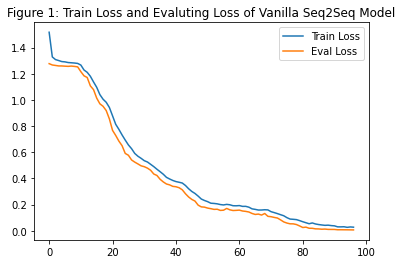

In [119]:
state = torch.load(MODEL_PATH_SEQ2SEQ_LOSS)

losses = state['losses']
train_losses = losses['train_losses']
valid_losses = losses['valid_losses']

plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), valid_losses)
plt.title('Figure 1: Train Loss and Evaluting Loss of Vanilla Seq2Seq Model')
plt.legend(['Train Loss', 'Eval Loss'], loc='upper right')
plt.show()

##### **Seq2Seq + Attention**

In [115]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=0)
decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128, attn_size=64)

state = torch.load(MODEL_PATH_SEQ2SEQ_ATTENTION)
encoder.load_state_dict(state['encoder'])
decoder.load_state_dict(state['decoder'])

predictions = predict(encoder, decoder, valid_x, tgt_vocab.itos, remove_ending=False)
groundtruth = [''.join(t) for t in valid_out]

print('Accuracy: %s' % accuracy_score(groundtruth, predictions))
print('Examples:')
for i in range(len(valid_inp[:20])):
    x = ''.join(valid_inp[i])
    y = ''.join(valid_out[i])
    
    print(f"+ {x} --> {y} --> {predictions[i]}")

Accuracy: 0.9996
Examples:
+ jjuvvmmmauuu --> ajmuv --> ajmuv
+ ceeeppnnn --> cenp --> cenp
+ iiikkxxaaijjjnnaaeee --> aeijknx --> aeijknx
+ hqqtttnnnooawwc --> achnoqtw --> achnoqtw
+ zzooeeeooonnzkhjhhh --> ehjknoz --> ehjknoz
+ aaaepppiitmbbb --> abeimpt --> abeimpt
+ wssrriidyyyf --> dfirswy --> dfirswy
+ kkuhhcrrzzmmmwww --> chkmruwz --> chkmruwz
+ cssxx --> csx --> csx
+ ddooouulllelllc --> cdelou --> cdelou
+ lllkkkaaaggfihrrr --> afghiklr --> afghiklr
+ ttgbbiillzocccuuu --> bcgilotuz --> bcgilotuz
+ lliiieeexiivvvtttrrrfffxx --> efilrtvx --> efilrtvx
+ parhhhylll --> ahlpry --> ahlpry
+ qqqccciialrrrvvvlzzz --> acilqrvz --> acilqrvz
+ cczppkq --> ckpqz --> ckpqz
+ ffffffsaa --> afs --> afs
+ kooopppwooeet --> ekoptw --> ekoptw
+ oyyyiiio --> ioy --> ioy
+ nnnyyxxuuufff --> fnuxy --> fnuxy


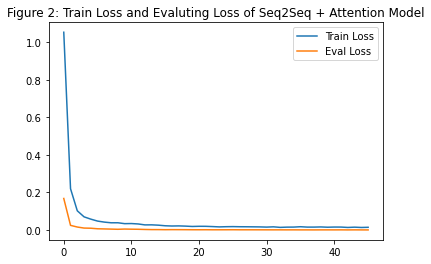

In [118]:
losses = state['losses']
train_losses = losses['train_losses']
valid_losses = losses['valid_losses']

plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), valid_losses)
plt.title('Figure 2: Train Loss and Evaluting Loss of Seq2Seq + Attention Model')
plt.legend(['Train Loss', 'Eval Loss'], loc='upper right')
plt.show()

#### With test data

In [0]:
test_x = map_many_elems(test_inp, src_vocab.stoi, seq_type='input', seq_length=58)
test_y = map_many_elems(test_out, tgt_vocab.stoi, seq_type='output', seq_length=13)

##### - **Vanilla Seq2Seq**

In [0]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=1)
decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128)

state_dict = torch.load(MODEL_PATH_SEQ2SEQ)
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])

predictions = predict(encoder, decoder, test_x, tgt_vocab.itos)
groundtruth = [''.join(t) for t in test_out]

accuracy_score(groundtruth, predictions)

0.9936

In [0]:
print(predictions[0:10])
print(groundtruth[0:10])

['cdfhjmqtuw', 'chmruvw', 'aehiklmrwxyz', 'hmprz', 'dgijmnoy', 'abflrsty', 'bjouy', 'clnqrsxz', 'ehptxz', 'fgv']
['cdfhjmqtuw', 'chmruvw', 'aehiklmrwxyz', 'hmprz', 'dgijmnoy', 'abflrsty', 'bjouy', 'clnqrsxz', 'ehptxz', 'fgv']


##### - **Seq2Seq + Attention**

In [0]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, hidden_dim=128, z_type=0)
decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, hidden_dim=128, attn_size=64)

state_dict = torch.load(MODEL_PATH_SEQ2SEQ_ATTENTION)
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])

predictions = predict(encoder, decoder, test_x, tgt_vocab.itos)
groundtruth = [''.join(t) for t in test_out]

accuracy_score(groundtruth, predictions)

0.9992

In [0]:
print(predictions[0:10])
print(groundtruth[0:10])

['cdfhjmqtuw', 'chmruvw', 'aehiklmrwxyz', 'hmprz', 'dgijmnoy', 'abflrsty', 'bjouy', 'clnqrsxz', 'ehptxz', 'fgv']
['cdfhjmqtuw', 'chmruvw', 'aehiklmrwxyz', 'hmprz', 'dgijmnoy', 'abflrsty', 'bjouy', 'clnqrsxz', 'ehptxz', 'fgv']


### 6. Analysis & Discussion


- With validation data set, the accuracy performance of 2 models are equivalent (**99.8%** vs **99.96%**). *Seq2Seq with Attention* overperforms slightly.
- With test data set, the accuracy performance of 2 models are also equivalent (**99.36%** vs **99.92%**). *Seq2Seq with Attention* also performs better slightly.
- `Figure 1` and `Figure 2` presents the loss at each epoch for *Vanilla Seq2Seq* model and *Seq2Seq with Attention* model. The loss function of *Seq2Seq with Attention* model converges quicker with less number of epoches than the *Vanilla Seq2Seq* model. That means with less computational step, *Seq2Seq with Attention* model will achieve an equivalent performance with *Vanilla Seq2Seq* model.
- Besides, one thing we can notice is the evaluating loss is less than training loss at each epoch step. This is unusual and interesting. However, it could be explained as the input and output has a clear formula of transformation that the output is ordered character-deduplicated string of the input. So that training and validating data set are genenerated without any human/third-party error. In this fashion, because there are less number of samples in validating set (5000/20000) and these samples may be not as difficult/long as in the training set, the model performs better in validating data set.


**Thank you for reading and happy weekend!**